In [1]:
import numpy as np
from sklearn.utils import resample


# configure bootstrap
n_iterations = 500

def bootstrap(a, b, calculate_statistic):
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        # prepare sample
        sample_a, sample_b = resample(a, b)
        stat = calculate_statistic(sample_a, sample_b)
        stats.append(stat)

    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
    
    return [lower, upper]

In [2]:
# virtual env Jupyter Notebook (sklearn0.19)
# load SVM results
import os
import glob
import pickle
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score


svm_results_dir = 'X:\\scratch\\ADNI\\Results'
svm_results_files = [ file for file in glob.glob(os.path.join(svm_results_dir,'ADNI-Vox*mci*','results.pickle'))]
temp_results_files = [ file for file in glob.glob(os.path.join(svm_results_dir,'ADNI-Vox*mci*','temp_results.pickle'))]
svm_results_files.sort()
print(svm_results_files)

features = {'/scratch/ebron/ADNI/adni_all_baseline_masked.csv': 'Modulated GM maps',
            '/scratch/ebron/ADNI/adni_all_t1_baseline_masked.csv': 'T1-weighted images',        
            }

# Load results, containing auc and acc means
svm_auc_means, svm_acc_means, svm_features = [], [], []
for svm_results_file in svm_results_files:
    print(svm_results_file)
    p = pickle.load(open(svm_results_file,'rb'))
    print(p.keys())
    
    svm_auc_means.append(p['auc_mean'])
    svm_acc_means.append(p['acc_mean'])
    svm_features.append(features[p['DataIn'][0]])
    svm_label = f"SVM" #with {p['N_splits']} iterations

# Load temp_results containing individual predictions
svm_y_trues, svm_y_scores, svm_y_preds, svm_auc_cis, svm_acc_cis = [], [], [], [], []
for temp_results_file in temp_results_files:
    print(temp_results_file)
    p = pickle.load(open(temp_results_file,'rb'))
    
    y_test = np.array(p[-3])
    y_score = np.array(p[-2])
    y_pred = np.array(p[-1])
    
    svm_y_trues.append(y_test)
    svm_y_scores.append(y_score)
    svm_y_preds.append(y_pred) 
    
    ci_auc = bootstrap(y_test, y_score[:,1], roc_auc_score) 
    ci_acc = bootstrap(y_test, y_pred, accuracy_score)  
    
    svm_auc_cis.append(ci_auc)
    svm_acc_cis.append(ci_acc)

d = {'svm_auc_means': svm_auc_means, 'svm_auc_cis': svm_auc_cis, 'svm_acc_means': svm_acc_means, 'svm_acc_cis': svm_acc_cis, 'svm_features': svm_features, 'svm_y_trues': svm_y_trues, 'svm_y_scores': svm_y_scores, 'svm_y_preds': svm_y_preds}
df_svm = pd.DataFrame(data=d)
#df_svm = df_svm.sort_values(['svm_class', 'svm_features'], ascending=[True,False])
print(df_svm)
    

['X:\\scratch\\ADNI\\Results\\ADNI-Vox-T1-mci-2020-04-03-14-44-41\\results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Vox-mci-2020-04-03-15-48-19\\results.pickle']
X:\scratch\ADNI\Results\ADNI-Vox-T1-mci-2020-04-03-14-44-41\results.pickle
dict_keys(['DataIn', 'DataTest', 'Labels', 'Factors', 'Biomarkers_exclude', 'ResultsFile', 'SaveResults', 'TempDirectory', 'InputTempFile', 'Type', 'TestClass', 'Iterations', 'N_splits', 'test_size', 'Kernel', 'DataDescription', 'UseSavedModel', 'DataInDirectory', 'DataTestDirectory', 'ResultsFolder', 'Timepoints', 'conf', 'best_c_values', 'accs', 'aucs', 'c_mean', 'c_std', 'acc_mean', 'acc_std', 'acc_95ci', 'auc_mean', 'auc_std', 'auc_95ci', 'computation_time[s]', 'nFeatures', 'nTrain', 'nClasses', 'ResultsDump', 'train', 'test', 'SubjectID'])
X:\scratch\ADNI\Results\ADNI-Vox-mci-2020-04-03-15-48-19\results.pickle
dict_keys(['DataIn', 'DataTest', 'Labels', 'Factors', 'Biomarkers_exclude', 'ResultsFile', 'SaveResults', 'TempDirectory', 'InputTempFile'

In [3]:
# load CNN results

import os
import glob
import pickle
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

cnn_auc_means, cnn_acc_means, cnn_features = [], [], []
features_cnn = {'GM': 'Modulated GM maps', 'T1': 'T1-weighted images'
            }

experiments=['16250_T1_WB_MCI_allCNN_notrain', '16254_GM_WB_MCI_allCNN_notrain']

cnn_y_trues, cnn_y_scores, cnn_y_preds, cnn_auc_cis, cnn_acc_cis = [], [], [], [], []
for exp in experiments:
    test_ids = np.load(os.path.join('W:','results', exp, 'train_test.npy')).item()['test'][0]
    
    test_results = np.load(os.path.join('W:','results', exp, 'results.npy')).item()['test']
    cnn_auc_means.append(test_results['auc'][0])
    cnn_acc_means.append(test_results['acc'][0])
    cnn_features_temp = exp.split('_')[1]
    cnn_features.append(features_cnn[cnn_features_temp])
    
    cnn_y_pred = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_pred.npy'))
    cnn_y_true = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_true.npy'))
    cnn_y_score = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_score.npy'))               

    # Sort on subject ids
    cnn_y_pred_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_pred))]
    cnn_y_true_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_true))]
    cnn_y_score_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_score))]
    
    cnn_y_trues.append(cnn_y_true_sorted )
    cnn_y_scores.append(cnn_y_score_sorted)
    cnn_y_preds.append(cnn_y_pred_sorted) 
    
    #Bootstrap
    cnn_y_score_sorted = [i[1] for i in cnn_y_score_sorted]
    cnn_ci_auc = bootstrap(cnn_y_true_sorted, cnn_y_score_sorted, roc_auc_score) 
    cnn_ci_acc = bootstrap(cnn_y_true_sorted, cnn_y_pred_sorted, accuracy_score)  
    
    cnn_auc_cis.append(cnn_ci_auc)
    cnn_acc_cis.append(cnn_ci_acc)
    
    
cnn_label = f"CNN" #with {len(results['auc'])} iterations

d = {'cnn_auc_means': cnn_auc_means, 'cnn_auc_cis': cnn_auc_cis, 'cnn_acc_means': cnn_acc_means, 'cnn_acc_cis': cnn_acc_cis, 'cnn_features': cnn_features, 'cnn_y_trues': cnn_y_trues, 'cnn_y_scores': cnn_y_scores, 'cnn_y_preds': cnn_y_preds}
df_cnn = pd.DataFrame(data=d)
print(df_cnn)

# restore np.load for future normal usage
np.load = np_load_old

95.0 confidence interval 68.7% and 75.8%
95.0 confidence interval 66.1% and 72.3%
95.0 confidence interval 70.9% and 77.6%
95.0 confidence interval 62.6% and 69.2%
   cnn_auc_means                               cnn_auc_cis  cnn_acc_means  \
0       0.723378  [0.6866211513878799, 0.7579074223411958]       0.692666   
1       0.742100  [0.7092615597220299, 0.7762234541929154]       0.657742   

                                cnn_acc_cis        cnn_features  \
0  [0.6612339930151339, 0.7229336437718277]  T1-weighted images   
1  [0.6256984866123398, 0.6915017462165308]   Modulated GM maps   

                                         cnn_y_trues  \
0  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
1  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   

                                        cnn_y_scores  \
0  [[0.22618622, 0.7738138], [0.1623768, 0.837623...   
1  [[0.64645535, 0.35354468], [0.08803751, 0.9119...   

                                         cnn_y_preds  
0  [1, 1,

In [4]:
# Calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

#print(cnn_y_true_sorted)
#print(svm_y_true)

def mcnemar_test(A_pred, A_true, B_pred, B_true):
    
    A_corr = np.array([1 if i==j else 0 for i,j in zip(A_pred, A_true)])
    B_corr = np.array([1 if i==j else 0 for i,j in zip(B_pred, B_true)])

    a = np.sum(np.sum([A_corr, B_corr],axis=0)==2)
    b = np.sum([1 if i==1 and j==0 else 0 for i,j in zip(A_corr, B_corr)])
    c = np.sum([1 if i==0 and j==1 else 0 for i,j in zip(A_corr, B_corr)])
    d = np.sum(np.sum([A_corr, B_corr],axis=0)==0)


    # define contingency table
    table = [[a, b], [c, d]]
    print(table)
    mcnemar_result = mcnemar(table, exact=False, correction=True)
    print(mcnemar_result)
          
    return mcnemar_result.pvalue

# test cnn vs svm
pvalues = []
for i, features in enumerate(df_cnn['cnn_features']):
    print(features)

    pvalue = mcnemar_test(df_cnn['cnn_y_preds'][i], df_cnn['cnn_y_trues'][i], df_svm['svm_y_preds'][i], df_svm['svm_y_trues'][i])    
    pvalues.append(pvalue)
df_svm['mcnemar_class'] = pvalues
df_cnn['mcnemar_class'] = pvalues

# test features
pvalue = mcnemar_test(df_cnn['cnn_y_preds'][0], df_cnn['cnn_y_trues'][0], df_cnn['cnn_y_preds'][1], df_cnn['cnn_y_trues'][1])    
df_cnn['mcnemar_feat'] = [pvalue, pvalue]

pvalue = mcnemar_test(df_svm['svm_y_preds'][0], df_svm['svm_y_trues'][0], df_svm['svm_y_preds'][1], df_svm['svm_y_trues'][1])    
df_svm['mcnemar_feat'] = [pvalue, pvalue]

print(df_svm)

T1-weighted images
[[497, 98], [96, 168]]
pvalue      0.9427644026876507
statistic   0.005154639175257732
Modulated GM maps
[[510, 55], [87, 207]]
pvalue      0.009282729146652815
statistic   6.767605633802817
[[478, 117], [87, 177]]
pvalue      0.04231527490571414
statistic   4.122549019607843
[[491, 102], [106, 160]]
pvalue      0.835219149785029
statistic   0.04326923076923077
   svm_auc_means                               svm_auc_cis  svm_acc_means  \
0       0.668166  [0.6270669190309828, 0.7094044131255555]       0.690338   
1       0.755742  [0.7215213610972747, 0.7867236831633277]       0.694994   

                                svm_acc_cis        svm_features  \
0  [0.6582945285215367, 0.7165599534342258]  T1-weighted images   
1  [0.6670547147846333, 0.7270372526193247]   Modulated GM maps   

                                         svm_y_trues  \
0  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
1  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   

              

In [5]:
# Function for plot labels
def autolabel(rects, xpos='center',decimals=2):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        float_format = '{:.' + str(decimals) + 'f}'
        ax.annotate(float_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

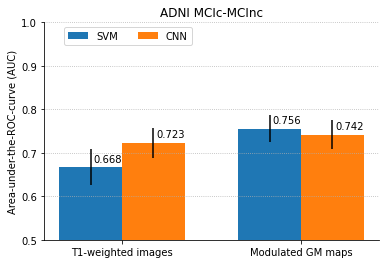

In [6]:
# Make plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from itertools import repeat


what='AUC'

# print(svm_auc_means)
# if what=='AUC':
#     svm_auc_means = svm_auc_means+list(repeat(0, len(cnn_auc_means)-len(svm_auc_means)))
#     cnn_auc_means = cnn_auc_means+list(repeat(0, len(svm_auc_means)-len(cnn_auc_means)))
# else:
#     svm_acc_means = svm_acc_means+list(repeat(0, len(cnn_acc_means)-len(svm_acc_means))) 
#     cnn_acc_means = cnn_acc_means+list(repeat(0, len(svm_acc_means)-len(cnn_acc_means))) 

ind = np.arange(len(svm_auc_means))  # the x locations for the groups
width = 0.35  # the width of the bars


fig, ax = plt.subplots()
if what=='AUC':
    rects1 = ax.bar(ind - width/2, df_svm['svm_auc_means'].tolist(), width, yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_svm['svm_auc_cis'], df_svm['svm_auc_means'])],
                    label=svm_label)
    rects2 = ax.bar(ind + width/2, df_cnn['cnn_auc_means'].tolist(), width, yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_cnn['cnn_auc_cis'], df_cnn['cnn_auc_means'])],
                    label=cnn_label)
else:
    rects1 = ax.bar(ind - width/2, df_svm['svm_acc_means'].tolist(), width, yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_svm['svm_acc_cis'], df_svm['svm_acc_means'])],
                    label=svm_label)
    rects2 = ax.bar(ind + width/2, df_cnn['cnn_acc_means'].tolist(), width, yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_cnn['cnn_acc_cis'], df_cnn['cnn_acc_means'])],
                    label=cnn_label)        

# Add some text for labels, title and custom x-axis tick labels, etc.
if what=='AUC':
    ax.set_ylabel('Area-under-the-ROC-curve (AUC)')
else:
    ax.set_ylabel('Accuracy')
ax.set_title('ADNI MCIc-MCInc')
ax.set_xticks(ind)
ax.set_xticklabels(cnn_features)
ax.set_ylim([0.5,1])
ax.grid(axis='y', linestyle='dotted')
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1), ncol=2)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

autolabel(rects1, "right", 3)
autolabel(rects2, "right", 3)


    # Custom function to draw the diff bars
if what!='AUC':
    # def label_diff(i,j,text,X,Y):
    #     x = (X[i]+X[j])/2
    #     y = 1.1*max(Y[i], Y[j])
    #     dx = abs(X[i]-X[j])

    #     props = {'connectionstyle':'bar','arrowstyle':'-',\
    #                  'shrinkA':20,'shrinkB':20,'linewidth':2}
    #     ax.annotate(text, xy=(X[i],y+7), zorder=10)
    #     ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

    # # Call the function
    # pvalue=df_svm['mcnemar']
    # label_diff(0-width/2, 0+width/2,f'p={pvalue}',ind,df_svm['svm_auc_means'])
    # #label_diff(2,3,f'p={pvalue}',ind,df_svm['svm_auc_means'])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':10,'shrinkB':10,'linewidth':1}
    
    # svm vs cnn
    for i in range(0,2):
        pvalue=df_svm['mcnemar_class'][i]
        if pvalue < 0.05 /4: 
            y = np.max([df_svm['svm_auc_means'][i], df_cnn['cnn_auc_means'][i]])
            ax.annotate(f'p={pvalue:.3f}', xy=(ind[i]-width/3,y+0.06))
            ax.annotate('', xy=(ind[i]-width/2,y), xytext=(ind[i]+width/2,y), arrowprops=props)
    # svm feat
    pvalue=df_svm['mcnemar_feat'][0]
    print(pvalue)
    if pvalue < 0.05 /4: 
        y = y + 0.1
        ax.annotate(f'p={pvalue:.3f}', xy=((ind[0] + ind[1]) / 2, y+0.06))
        ax.annotate('', xy=(ind[0]-width/2,y), xytext=(ind[1]-width/2,y), arrowprops=props)   
    # cnn feat
    pvalue=df_cnn['mcnemar_feat'][0]
    print(pvalue)
    if pvalue < 0.05 /4: 
        y = y + 0.1
        ax.annotate(f'p={pvalue:.3f}', xy=((ind[0] + ind[1]) / 2, y+0.06))
        ax.annotate('', xy=(ind[0]+width/2,y), xytext=(ind[1]+width/2,y), arrowprops=props)          

#fig.tight_layout()

plt.show()

# Converting datetime object to string
dateTimeObj = datetime.now()
 
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H-%M")

if what=='AUC':
    figure_name = f'Plot2_MCI_CNNSVM_{timestampStr}'
else:
    figure_name = f'Plot2_MCI_CNNSVM_Acc_{timestampStr}'
fig.savefig(figure_name, dpi=300, facecolor='w', edgecolor='w', bbox_extra_artists=(lgd,), bbox_inches='tight')